In [20]:
!pip install augmentor

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tnrange, tqdm_notebook, tqdm
import matplotlib.pyplot as plt
import Augmentor
import pandas as pd
import numpy as np


In [0]:
p = Augmentor.Pipeline()
#p.flip_left_right(probability=0.5)
p.rotate(probability=0.6, max_left_rotation=9, max_right_rotation=9)
p.zoom_random(0.8, percentage_area=0.95)
#p.random_distortion(probability=1, grid_width=1, grid_height=1, magnitude=1)


transforms1 = torchvision.transforms.Compose([
    p.torch_transform(),
    torchvision.transforms.ToTensor()
])

In [23]:
dataset = torchvision.datasets.MNIST(
    root='./data'
    ,train=True
    ,download=True #set this as true to download the data
    ,transform=transforms1)

print(len(dataset))
train_set, val_set = torch.utils.data.random_split(dataset, [57000, 3000])

60000


Label: 1


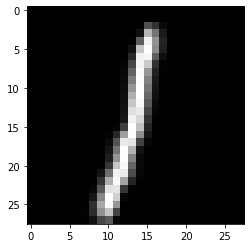

In [24]:
sample = next(iter(train_set))
image,label = sample #sequence unpacking
plt.imshow(image.squeeze(), cmap="gray")
print("Label:", label)

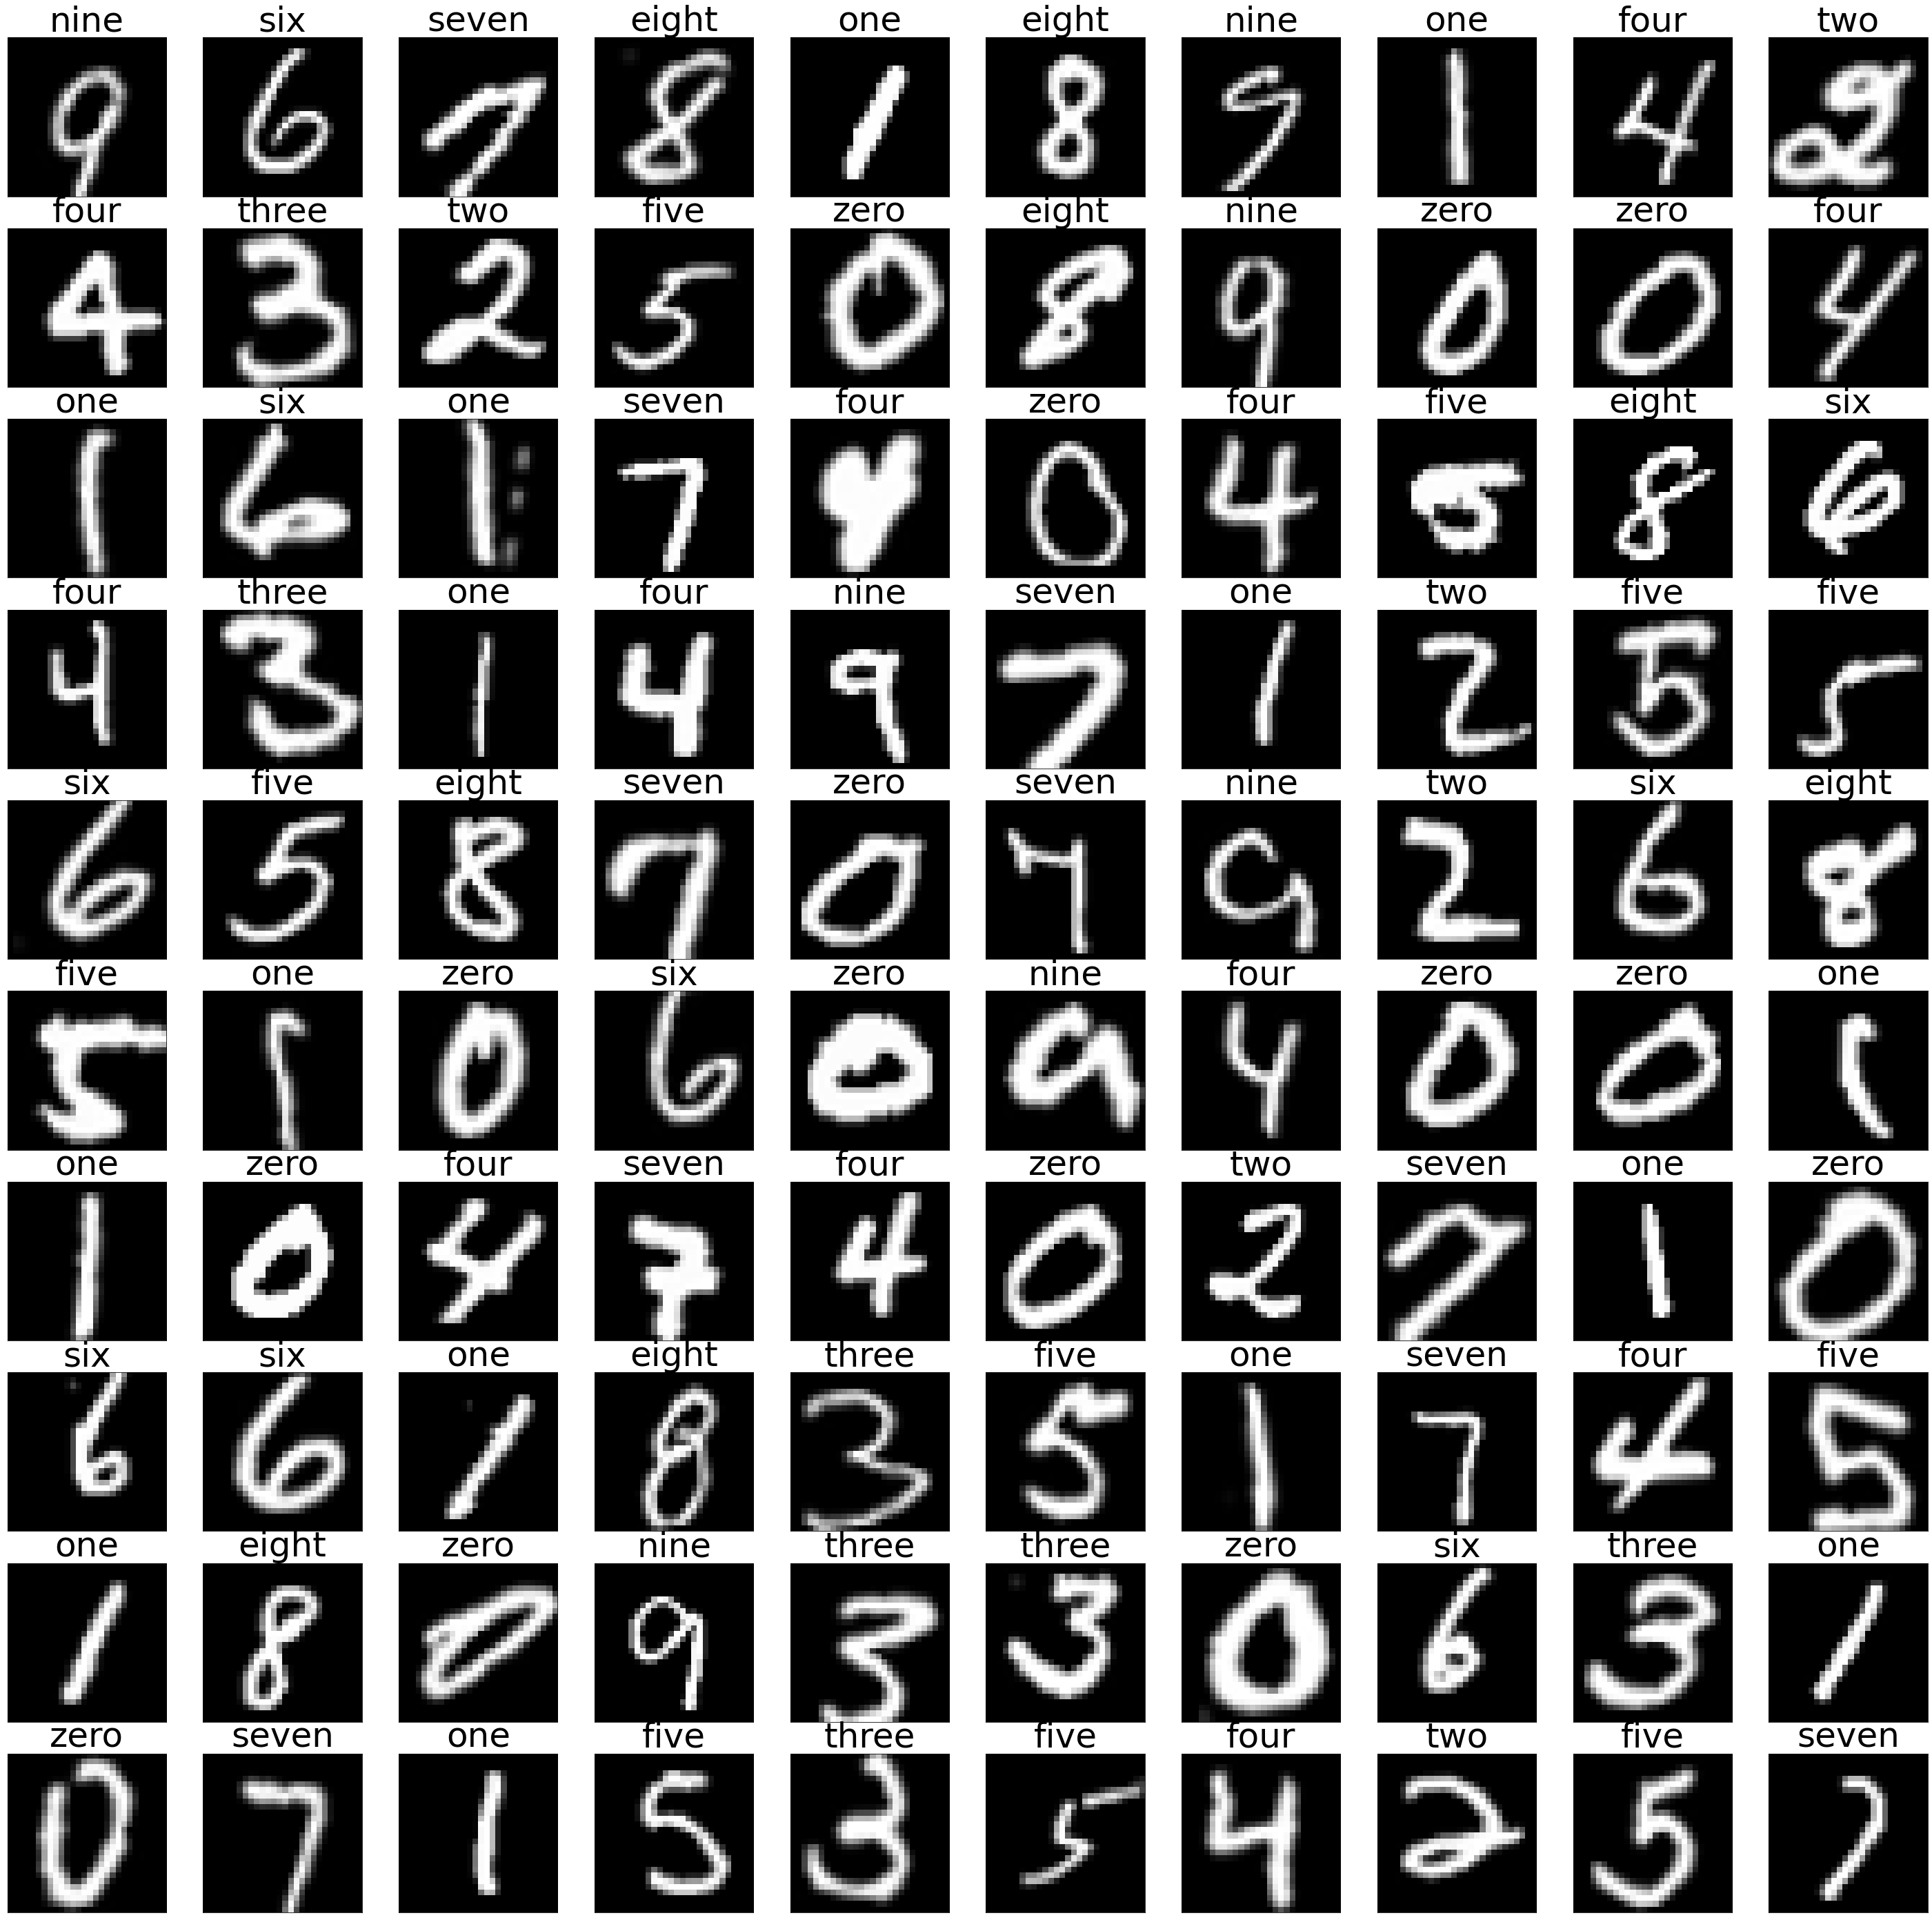

In [25]:
how_many_to_plot = 100

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=1, shuffle=True
)

mapping = {
    0:'zero', 1:'one', 2:'two', 3:'three', 4:'four'
    ,5:'five', 6:'six', 7:'seven', 8:'eight', 9:'nine'
}

plt.figure(figsize=(50,50))
for i, batch in enumerate(train_loader, start=1):
    image, label = batch
    plt.subplot(10,10,i)
    fig = plt.imshow(image.reshape(28,28), cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(mapping[label.item()], fontsize=50)
    if (i >= how_many_to_plot): break
plt.show()

# prints 100 instances from the training data

In [0]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)
        
    def forward(self, t):
        # (1) input layer
        t=t
        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        # 4,4 are height of each of the 12 output channels
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)
        

        return t

In [0]:
network=Network()





In [0]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
optimizer = optim.Adam(network.parameters(), lr=0.01)
train_loader = torch.utils.data.DataLoader(
    train_set
    ,batch_size=1000
    ,shuffle=True,
)

val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=1000, shuffle=False
)


In [0]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [30]:
loss_list=[]
acc_list=[]
val_loss_list=[]
val_acc_list=[]

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

for epoch in tnrange(20):
    

    total_loss = 0
    total_correct = 0
    total_loss2 = 0
    total_correct2 = 0



    

    for batch in tqdm_notebook(train_loader): # Get Batch
        images, labels = batch 

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    with torch.no_grad():
      print("Validating......")
      network.eval()
      for batch2 in tqdm_notebook(val_loader): # Get Batch
          images2, labels2 = batch2
          preds2 = network(images2) # Pass Batch
          total_loss2 += loss.item()
          total_correct2 += get_num_correct(preds, labels)

    print(
        "epoch", epoch, 
        "total_correct:", total_correct, 
        "loss:", total_loss/57000, 
        "val_loss", total_loss2/3000,
        "val_correct", total_correct2
    )
    
    loss_list.append(total_loss/57000)
    acc_list.append(total_correct/57000)
    val_loss_list.append(total_loss2/3000)
    val_acc_list.append(total_correct2/3000)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Validating......


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epoch 0 total_correct: 45030 loss: 0.0006425248065538573 val_loss 0.00018064860999584197 val_correct 2823



Validating......



epoch 1 total_correct: 54594 loss: 0.00013474189307083163 val_loss 0.00011261951923370361 val_correct 2892



Validating......



epoch 2 total_correct: 55353 loss: 9.086398741132335e-05 val_loss 9.01101753115654e-05 val_correct 2922



Validating......



epoch 3 total_correct: 55633 loss: 7.617937080692827e-05 val_loss 8.474580943584442e-05 val_correct 2934



Validating......



epoch 4 total_correct: 55866 loss: 6.569470602430796e-05 val_loss 4.5637499541044235e-05 val_correct 2964



Validating......



epoch 5 total_correct: 55919 loss: 5.966902105954656e-05 val_loss 6.2210813164711e-05 val_correct 2937



Validating......



epoch 6 total_correct: 56119 loss: 5.015543812330355e-05 val_loss 5.311410129070282e-05 val_correct 2952



Validating......



epoch 7 total_correct: 56090 loss: 5.02221335640602e-05 val_loss 3.803178295493126e-05 val_correct 2964



Validating......



epoch 8 total_correct: 56184 loss: 4.528842526569701e-05 val_loss 6.909503787755967e-05 val_correct 2943



Validating......



epoch 9 total_correct: 56175 loss: 4.80940543245851e-05 val_loss 3.889136016368866e-05 val_correct 2967



Validating......



epoch 10 total_correct: 56230 loss: 4.329390333671319e-05 val_loss 5.623437836766243e-05 val_correct 2952



Validating......



epoch 11 total_correct: 56291 loss: 3.95472526484937e-05 val_loss 4.8064850270748137e-05 val_correct 2955



Validating......



epoch 12 total_correct: 56282 loss: 3.946223863188112e-05 val_loss 2.7822313830256462e-05 val_correct 2976



Validating......



epoch 13 total_correct: 56349 loss: 3.512342914677503e-05 val_loss 3.7340525537729266e-05 val_correct 2973



Validating......



epoch 14 total_correct: 56312 loss: 3.875764240429067e-05 val_loss 3.5497158765792846e-05 val_correct 2961



Validating......



epoch 15 total_correct: 56346 loss: 3.738822784732308e-05 val_loss 4.922709241509438e-05 val_correct 2952



Validating......



epoch 16 total_correct: 56394 loss: 3.478352477153142e-05 val_loss 3.31290103495121e-05 val_correct 2967



Validating......



epoch 17 total_correct: 56396 loss: 3.3440212245311656e-05 val_loss 1.746189221739769e-05 val_correct 2985



Validating......



epoch 18 total_correct: 56376 loss: 3.387733164913299e-05 val_loss 2.8298789635300637e-05 val_correct 2964



Validating......



epoch 19 total_correct: 56326 loss: 3.593217692615693e-05 val_loss 4.3727584183216094e-05 val_correct 2961



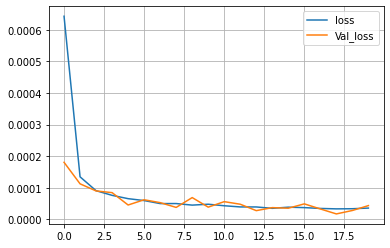

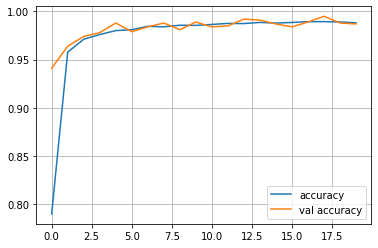

In [31]:
plt.plot(loss_list, label='loss')
plt.plot(val_loss_list, label='Val_loss')
plt.grid()
plt.legend()
plt.show()

plt.plot(acc_list, label='accuracy')
plt.plot(val_acc_list, label = 'val accuracy')
plt.grid()
plt.legend()

In [0]:
torch.save(network.state_dict(), 'model_40.pt')

In [33]:
network.load_state_dict(torch.load('model_40.pt'))

<All keys matched successfully>

In [0]:
test_set = torchvision.datasets.MNIST(
    root='./data'
    ,train=False
    ,download=True #set this as true to download the data
    ,transform=transforms.Compose([
        transforms.ToTensor()
    ])
)


test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=1000, shuffle=False
)


In [35]:
loss_list_2=[]
acc_list_2=[]
total_loss = 0
total_correct = 0


with torch.no_grad():
  network.eval()
  for batch in tqdm_notebook(test_loader): # Get Batch
      images, labels = batch 
      preds = network(images) # Pass Batch
      total_loss += loss.item()
      total_correct += get_num_correct(preds, labels)

print(total_correct, "out of 10000.")
print("Which corresponds to", total_correct/100, "% accuracy.") 
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



9908 out of 10000.
Which corresponds to 99.08 % accuracy.


In [0]:
def load_test_csv_dataset(csv_path):
    test_data_table = pd.read_csv(csv_path)
    test_x = test_data_table.values.astype(np.float32)

    test_x = test_x.reshape([-1, 28, 28, 1]).transpose((0, 3, 1, 2))

    return test_x


In [0]:
test_x = load_test_csv_dataset('./test.csv')
test_x = torch.from_numpy(test_x)

# Init model, restore its weights and set to eval mode.
model = Network()
model.load_state_dict(torch.load('./model_40.pt'))
model.eval()

test_labels = []
for i in range(len(test_x)):
    test_batch = test_x[i].unsqueeze_(0)

    output = model(test_batch)
    _, output = torch.max(output, dim=1)

    test_labels.append(int(output.data.numpy()))

In [41]:
print(test_labels)

[2, 0, 9, 9, 3, 7, 0, 3, 0, 3, 5, 7, 4, 0, 4, 3, 3, 1, 9, 0, 9, 1, 1, 5, 7, 4, 2, 7, 8, 7, 7, 5, 4, 2, 6, 2, 5, 5, 1, 6, 7, 7, 4, 9, 8, 7, 8, 2, 6, 7, 6, 8, 8, 3, 8, 2, 1, 2, 2, 0, 4, 1, 7, 0, 0, 0, 1, 9, 0, 1, 6, 5, 8, 8, 2, 8, 9, 9, 2, 3, 5, 4, 1, 0, 9, 2, 4, 3, 6, 7, 2, 0, 6, 6, 1, 4, 3, 9, 7, 4, 0, 9, 2, 0, 7, 3, 0, 5, 0, 8, 0, 0, 4, 7, 1, 7, 1, 1, 3, 3, 3, 7, 2, 8, 6, 3, 8, 7, 8, 4, 3, 5, 6, 0, 0, 0, 3, 1, 3, 6, 4, 3, 4, 5, 5, 8, 7, 7, 2, 8, 4, 3, 5, 6, 5, 3, 7, 5, 7, 8, 3, 0, 4, 5, 1, 3, 7, 6, 3, 0, 2, 7, 8, 6, 1, 3, 7, 4, 1, 2, 4, 8, 5, 2, 4, 9, 2, 1, 6, 0, 6, 1, 4, 9, 6, 0, 9, 7, 6, 9, 1, 9, 0, 9, 9, 0, 8, 4, 6, 2, 0, 9, 3, 6, 3, 2, 1, 6, 3, 4, 2, 3, 1, 2, 2, 0, 4, 6, 1, 0, 0, 4, 9, 1, 7, 3, 2, 3, 8, 6, 8, 6, 2, 8, 5, 5, 4, 8, 3, 5, 9, 7, 1, 3, 8, 4, 5, 1, 4, 5, 6, 3, 3, 5, 7, 0, 6, 8, 3, 1, 6, 0, 6, 3, 9, 5, 1, 5, 8, 4, 0, 9, 2, 0, 5, 3, 7, 1, 9, 9, 5, 7, 7, 9, 9, 6, 3, 0, 3, 3, 6, 9, 8, 2, 6, 3, 7, 1, 4, 5, 8, 5, 9, 0, 0, 3, 8, 4, 1, 8, 4, 1, 1, 9, 8, 4, 5, 1, 5, 3, 6, 3, 1, 

In [42]:
submission = pd.read_csv('./sample_submission.csv')
submission['Label'] = test_labels
submission.to_csv('./sample_submission2.csv', index=False)
submission

ImageId  Label
0            1      2
1            2      0
2            3      9
3            4      9
4            5      3
...        ...    ...
27995    27996      9
27996    27997      7
27997    27998      3
27998    27999      9
27999    28000      2

[28000 rows x 2 columns]